### 1. Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import seaborn as sns
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import datetime


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, add, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow import keras
import keras_tuner as kt

In [2]:
# conda install -c conda-forge keras-tuner
# !pip install keras-tuner --upgrade

In [3]:
tf.random.set_seed(42)

### 2. Przygotowanie datasetu

In [4]:
def load_images_from_folder(folder,only_path = False, label = ""):
# Load the paths to the images in a directory
# or load the images
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [5]:
images = []
dirp = r'Apple/'
for f in os.listdir(dirp):
    if "png" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else: 
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)
            
# Create a dataframe with the paths and the label for each apple
df = pd.DataFrame(images, columns = ["apple", "path"])

# Shuffle the dataset
from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Assign to each apple a specific number
apple_names = sorted(df.apple.unique())
mapper_apple_names = dict(zip(apple_names, [t for t in range(len(apple_names))]))
df["label"] = df["apple"].map(mapper_apple_names)
print(mapper_apple_names)

# Visualize the resulting dataframe
df.head()

{'Apple A': 0, 'Apple B': 1, 'Apple C': 2, 'Apple D': 3, 'Apple E': 4, 'Apple F': 5}


,apple,path,label
0,Apple D,Apple/Apple D\Apple De09041.png,3
1,Apple D,Apple/Apple D\Apple De01561.png,3
2,Apple D,Apple/Apple D\applee13281.png,3
3,Apple F,Apple/Apple F\Apple F _0_7330.png,5
4,Apple A,Apple/Apple A\Apple 321.png,0


In [6]:
df.label.unique()

array([3, 5, 0, 4, 2, 1], dtype=int64)

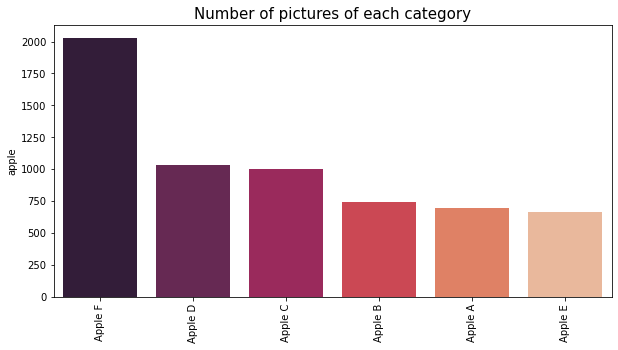

In [7]:
# Display the number of pictures of each category
vc = df["apple"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

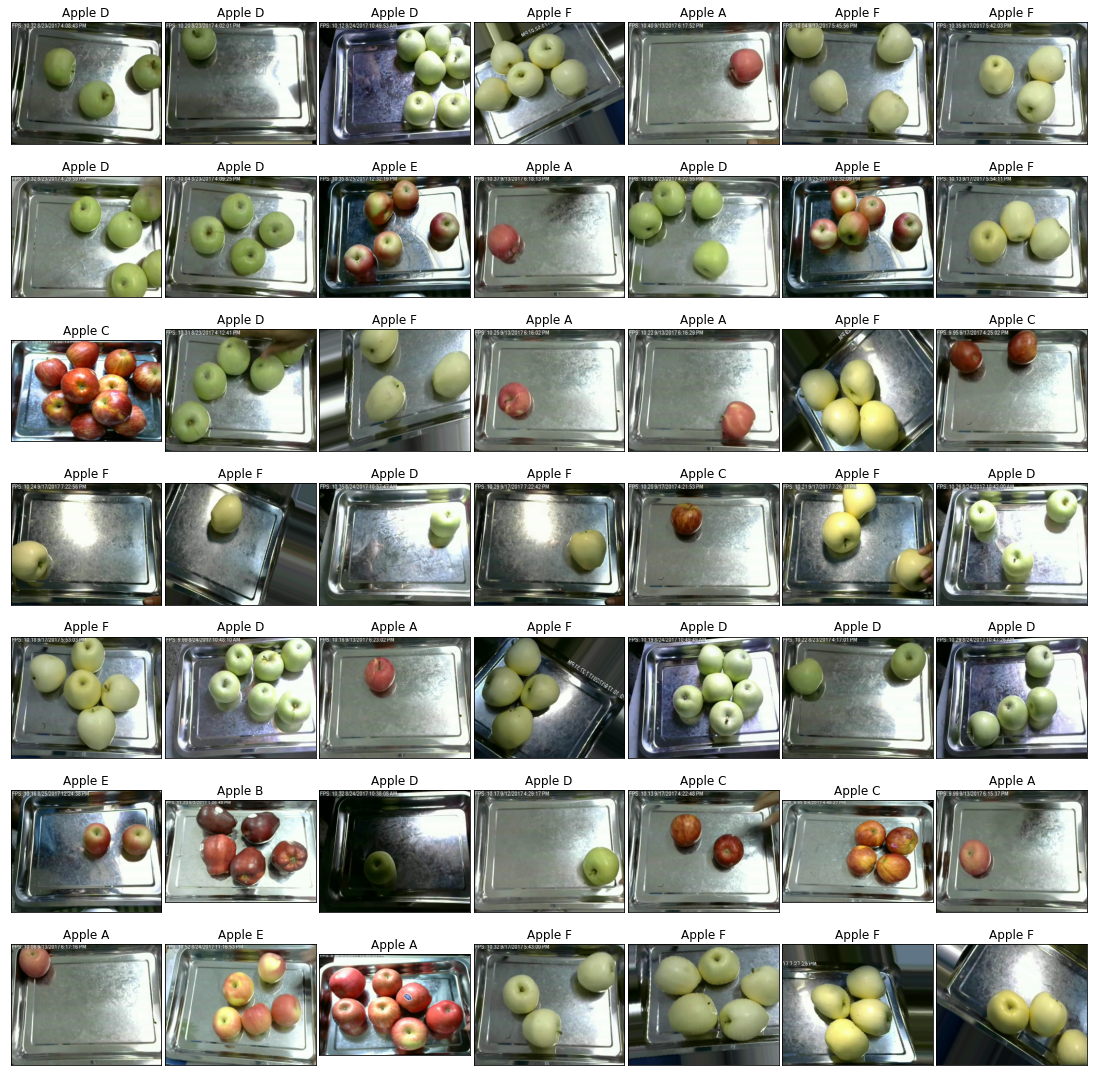

In [8]:
fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.apple[i], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

In [9]:
# fetching the dimensions

widths = []
heights = []

for im in df.path:
    img = cv2.imread(im)                      
    widths.append(img.shape[1])
    heights.append(img.shape[0])

AVG_HEIGHT = round(sum(heights)/len(heights))
AVG_WIDTH = round(sum(widths)/len(widths))

In [10]:
print(set(widths))
print(set(heights))
print(AVG_HEIGHT)
print(AVG_WIDTH)

{320, 480}
{258, 322}
272
355


In [11]:
from collections import Counter


print(Counter(widths).keys())
print(Counter(widths).values())

dict_keys([320, 480])
dict_values([4820, 1341])


In [12]:
print(Counter(heights).keys())
print(Counter(heights).values())

dict_keys([258, 322])
dict_values([4820, 1341])


In [13]:
from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

In [14]:
df.head()

,apple,path,label
0,Apple F,Apple/Apple F\Apple F102.png,5
1,Apple C,Apple/Apple C\scene00281.png,2
2,Apple B,Apple/Apple B\253red applee03601253.png,1
3,Apple F,Apple/Apple F\Apple F _0_4165.png,5
4,Apple B,Apple/Apple B\510red applee01821510.png,1


In [15]:
# def load_img(df):
#     img_paths = df["path"].values
#     resized_photos = []
#     labels= []
#     for idx, path in enumerate(img_paths):
#         w=img.shape[1]
#         img =  plt.imread(path)
#         if w==480:
#             cropped_img=img[0:322, 79:401]
#             resized_img=cv2.resize(cropped_img, (258,258))
#             resized_photos.append(resized_img)
#             labels.append(df.label.values[idx])
#         else:
#             cropped_img=img[0:258, 31:289]
#             resized_photos.append(cropped_img)
#             labels.append(df.label.values[idx])
#     return np.array(resized_photos),np.array(labels)

In [16]:
img_paths = df["path"].values
resized_photos = []
labels= []
for idx, path in enumerate(img_paths):
    w=img.shape[1]
    img =  plt.imread(path)
    if w==480:
        cropped_img=img[0:322, 79:401]
        resized_img=cv2.resize(cropped_img, (258,258))
        resized_photos.append(resized_img)
        labels.append(df.label.values[idx])
    else:
        cropped_img=img[0:258, 31:289]
        resized_photos.append(cropped_img)
        labels.append(df.label.values[idx])
X=np.array(resized_photos)
y=np.array(labels)

### 3. Podział datasetu

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
# transformujemy y_test
y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()
# podglądamy
y_test = y_test.astype(np.float32)

# transformujemy y_train
y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1)).toarray()
# podglądamy
y_train = y_train.astype(np.float32)

print("y_test.shape: ", y_test.shape)
print("y_train.shape: ", y_train.shape)

y_test.shape:  (1233, 6)
y_train.shape:  (4928, 6)


In [18]:
print("x_train shape: ", X_train.shape)
print("x_test shape: ", X_test.shape)

x_train shape:  (4928, 258, 258, 3)
x_test shape:  (1233, 258, 258, 3)


In [19]:
# zmieniamy shape pod konwolucje
X_test = X_test.reshape(-1,258,258,3)
X_train = X_train.reshape(-1,258,258,3)

In [20]:
X_test.ndim

4

In [21]:
batch_size = 30
X_train.shape[0]%batch_size

8

In [22]:
input_shape=X_train.shape[1:]
input_shape

(258, 258, 3)

### 4. Optymalizacja modelu (Keras Tuner) - 2 warstwy konwolucyjne

In [ ]:
# model przygotowany pod tuning

def build_model_2_leyers(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=8, max_value=120, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=input_shape),
    # adding pooling
    keras.layers.MaxPool2D(pool_size=(2, 2),strides=2,padding="SAME"),
        
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=8, max_value=120, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'),
    # adding pooling
    keras.layers.MaxPool2D(pool_size=(2, 2),strides=2,padding="SAME"),
        
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    # adding dropout layer
    keras.layers.Dropout(
        hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)),
    # output layer    
    keras.layers.Dense(6, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

In [ ]:
# # warstwa wejściowa
# inputLayer = tf.keras.Input(shape=(input_shape))
# # 1. konwulucyjna
# x = layers.Conv2D(24, kernel_size=3, activation='relu', strides=1, padding='valid')(inputLayer)
# x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
# # 2. konwulucyjna
# x = layers.Conv2D(56, kernel_size=5, activation='relu', strides=1, padding='valid')(x)
# x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
# x = layers.Flatten()(x)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.Dropout(0.1)(x)
# out = layers.Dense(6, activation="softmax")(x)


In [ ]:
# importing random search
from keras_tuner import RandomSearch

#creating randomsearch object
tuner = RandomSearch(build_model_2_leyers,
                    objective='val_accuracy',
                    max_trials = 5,
                    directory='test')
# search best parameter
tuner.search(X_train,y_train,epochs=3,validation_split=0.05)

In [ ]:
model_2_layers=tuner.get_best_models(num_models=1)[0]
#summary of best model
model_2_layers.summary()

In [ ]:
# sprawdzić jak wydostać te informacje

params_2=tuner.get_best_hyperparameters()
print(params_2)

In [ ]:
model_2_layers.get_config()

In [ ]:
history_2_layers = model_2_layers.fit(X_train,y_train,
                                      batch_size=30,
                                      epochs=15,
                                      validation_split=0.05,
                                      initial_epoch=3)

In [ ]:
# jakie wartości przechowuje historia wyników
history_2_layers.history.keys()

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history_2_layers.history["loss"])
ax[0][1].plot(history_2_layers.history["accuracy"])
ax[1][0].plot(history_2_layers.history["val_loss"])
ax[1][1].plot(history_2_layers.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [ ]:
# testowanie
y_pred_2_layers = model_2_layers.predict(X_test)
print(classification_report(y_test.argmax(axis=1), y_pred_2_layers.argmax(axis=1)))

In [ ]:
y_test_arg=np.argmax(y_test,axis=1)
Y_pred_2_layers = np.argmax(model_2_layers.predict(X_test),axis=1)
print('Confusion Matrix')
print(pd.DataFrame(confusion_matrix(y_test_arg, Y_pred_2_layers)))

In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# # This callback will stop the training when there is no improvement in
# # the loss for three consecutive epochs.
# model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
# model.compile(tf.keras.optimizers.SGD(), loss='mse')
# history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
#                     epochs=10, batch_size=1, callbacks=[callback],
#                     verbose=0)
# len(history.history['loss'])  # Only 4 epochs are run.

### 5. Optymalizacja modelu (Keras Tuner) - 3 warstwy konwolucyjne

wyniki złe, zanik sygnału

In [ ]:
# model przygotowany pod tuning

def build_model_3_leyers(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=8, max_value=120, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation=hp.Choice('conv_1_activation', values = ['tanh','relu']),
        input_shape=input_shape),
    # adding pooling
    keras.layers.MaxPool2D(pool_size=(2, 2),strides=2,padding="valid"),
        
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=8, max_value=120, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation=hp.Choice('conv_2_activation', values = ['tanh','relu'])),
    # adding pooling
    keras.layers.MaxPool2D(pool_size=(2, 2),strides=2,padding="valid"),
        
    # adding third convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_3_filter', min_value=8, max_value=120, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        #activation function
        activation=hp.Choice('conv_3_activation', values = ['tanh','relu'])),
    # adding pooling
    keras.layers.MaxPool2D(pool_size=(2, 2),strides=2,padding="valid"),
        
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    # adding dropout layer
    keras.layers.Dropout(
        hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)),
    # output layer    
    keras.layers.Dense(6, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

In [ ]:
# importing random search
from keras_tuner import RandomSearch

#creating randomsearch object
tuner = RandomSearch(build_model_3_leyers,
                    objective='val_accuracy',
                    max_trials = 5,
                    directory='test_2')
# search best parameter
tuner.search(X_train,y_train,epochs=3,validation_split=0.05)

In [ ]:
model_3_layers=tuner.get_best_models(num_models=1)[0]
#summary of best model
model_3_layers.summary()

In [ ]:
# Signature: tuner.get_best_models(num_models=1)
# Docstring:
# Returns the best model(s), as determined by the tuner's objective.

# The models are loaded with the weights corresponding to
# their best checkpoint (at the end of the best epoch of best trial).

# This method is for querying the models trained during the search.
# For best performance, it is recommended to retrain your Model on the
# full dataset using the best hyperparameters found during `search`,
# which can be obtained using `tuner.get_best_hyperparameters()`.

# Args:
#     num_models: Optional number of best models to return.
#         Defaults to 1.

# Returns:
#     List of trained model instances sorted from the best to the worst.

In [ ]:
model_3_layers.get_config()

In [ ]:
history_3_layers = model_3_layers.fit(X_train,y_train,
                                      batch_size=30,
                                      epochs=15,
                                      validation_split=0.05,
                                      initial_epoch=3)

In [ ]:
# jakie wartości przechowuje historia wyników
history_3_layers.history.keys()

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history_3_layers.history["loss"])
ax[0][1].plot(history_3_layers.history["accuracy"])
ax[1][0].plot(history_3_layers.history["val_loss"])
ax[1][1].plot(history_3_layers.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [ ]:
# testowanie
y_pred_3_layers = model_3_layers.predict(X_test)
print(classification_report(y_test.argmax(axis=1), y_pred_3_layers.argmax(axis=1)))

In [ ]:
y_test_arg=np.argmax(y_test,axis=1)
Y_pred_3_layers = np.argmax(model_3_layers.predict(X_test),axis=1)
print('Confusion Matrix')
print(pd.DataFrame(confusion_matrix(y_test_arg, Y_pred_3_layers)))

### 6. Sprawdzenie zoptymalizowanego modelu - 2 warstwy konwolucyjne

In [ ]:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv2d (Conv2D)             (None, 256, 256, 24)      672       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 24)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 56)      12152     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 56)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 222264)            0         
                                                                 
 dense (Dense)               (None, 112)               24893680  
                                                                 
 dropout (Dropout)           (None, 112)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 678       
                                                                 
=================================================================
Total params: 24,907,182
Trainable params: 24,907,182
Non-trainable params: 0
___________________________

In [ ]:
{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 258, 258, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv2d_input'}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'batch_input_shape': (None, 258, 258, 3),
    'dtype': 'float32',
    'filters': 24,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d',
    'trainable': True,
    'dtype': 'float32',
    'pool_size': (2, 2),
    'padding': 'same',
    'strides': (2, 2),
    'data_format': 'channels_last'}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 56,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_1',
    'trainable': True,
    'dtype': 'float32',
    'pool_size': (2, 2),
    'padding': 'same',
    'strides': (2, 2),
    'data_format': 'channels_last'}},
  {'class_name': 'Flatten',
   'config': {'name': 'flatten',
    'trainable': True,
    'dtype': 'float32',
    'data_format': 'channels_last'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'units': 112,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.0,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 6,
    'activation': 'softmax',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}}]}

In [23]:
model_2_layers_to_check = keras.models.Sequential([
    
    keras.layers.Conv2D(filters=24, kernel_size=3, strides=1, activation='relu', padding="valid", input_shape=input_shape),
#     keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    keras.layers.Conv2D(filters=56, kernel_size=3, strides=1, activation='relu', padding="valid"),
#     keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(112, activation='relu'),
    keras.layers.Dropout(0),

    keras.layers.Dense(6, activation='softmax')
])

In [24]:
model_2_layers_to_check.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 24)      672       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 24)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 56)      12152     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 56)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 222264)            0         
                                                                 
 dense (Dense)               (None, 112)               2

In [25]:
# # dodajemy zapisywanie logów do tensorboard'a
# log_dir = "logs\\warstwy_2_do_potwierdzenia" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [26]:
model_2_layers_to_check.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [27]:
history_2_layers_to_check = model_2_layers_to_check.fit(X_train, y_train,
                             batch_size=30,
                             epochs=15, 
#                              callbacks=[callback],
                             validation_split=0.05,
                             verbose=1)

Epoch 1/15
157/157 [==============================] - 188s 1s/step - loss: 1.3887 - accuracy: 0.4653 - val_loss: 0.8343 - val_accuracy: 0.6721
Epoch 2/15
157/157 [==============================] - 177s 1s/step - loss: 0.4722 - accuracy: 0.8556 - val_loss: 0.3433 - val_accuracy: 0.8988
Epoch 3/15
157/157 [==============================] - 181s 1s/step - loss: 0.2080 - accuracy: 0.9378 - val_loss: 0.3133 - val_accuracy: 0.8907
Epoch 4/15
157/157 [==============================] - 177s 1s/step - loss: 0.1783 - accuracy: 0.9504 - val_loss: 0.1450 - val_accuracy: 0.9555
Epoch 5/15
157/157 [==============================] - 181s 1s/step - loss: 0.0823 - accuracy: 0.9793 - val_loss: 0.1142 - val_accuracy: 0.9676
Epoch 6/15
157/157 [==============================] - 183s 1s/step - loss: 0.0623 - accuracy: 0.9857 - val_loss: 0.1161 - val_accuracy: 0.9717
Epoch 7/15
157/157 [==============================] - 182s 1s/step - loss: 0.0605 - accuracy: 0.9831 - val_loss: 0.0804 - val_accuracy: 0.9676

In [28]:
# jakie wartości przechowuje historia wyników
history_2_layers_to_check.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

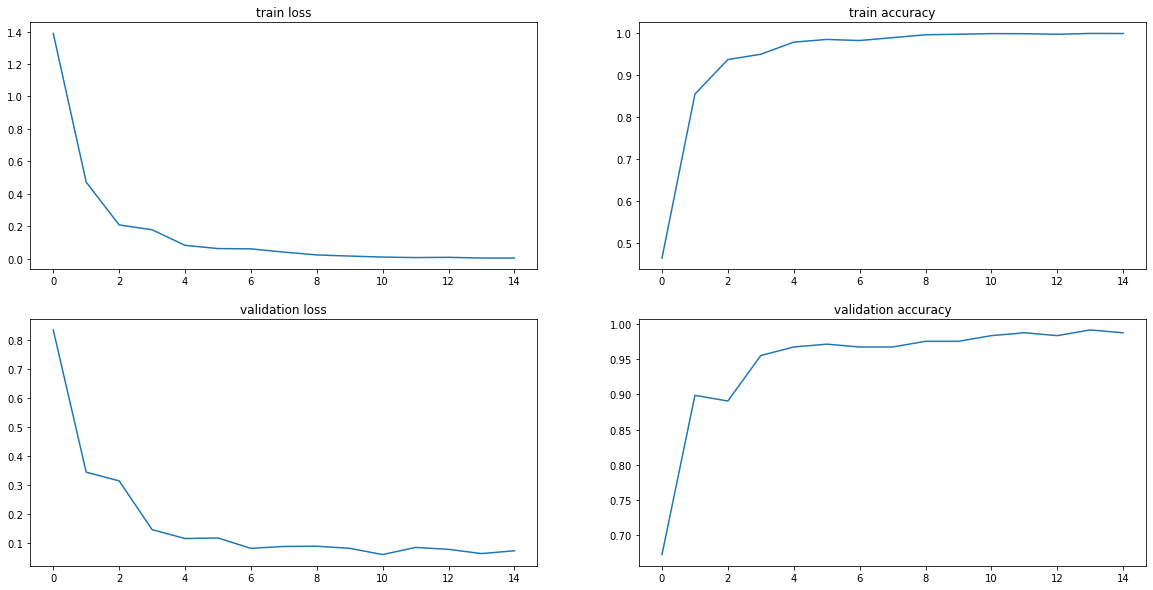

In [29]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history_2_layers_to_check.history["loss"])
ax[0][1].plot(history_2_layers_to_check.history["accuracy"])
ax[1][0].plot(history_2_layers_to_check.history["val_loss"])
ax[1][1].plot(history_2_layers_to_check.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [30]:
# testowanie
y_pred_temp_2_layers_to_check = model_2_layers_to_check.predict(X_test)
print(classification_report(y_test.argmax(axis=1), y_pred_temp_2_layers_to_check.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       138
           1       0.98      0.99      0.99       148
           2       0.99      0.98      0.99       201
           3       0.96      1.00      0.98       207
           4       0.99      0.98      0.99       133
           5       0.99      0.98      0.99       406

    accuracy                           0.98      1233
   macro avg       0.98      0.99      0.98      1233
weighted avg       0.98      0.98      0.98      1233



In [31]:
y_test_arg=np.argmax(y_test,axis=1)
Y_pred_temp_2_layers_to_check = np.argmax(model_2_layers_to_check.predict(X_test),axis=1)
print('Confusion Matrix')
print(pd.DataFrame(confusion_matrix(y_test_arg, Y_pred_temp_2_layers_to_check)))

Confusion Matrix
     0    1    2    3    4    5
0  136    1    0    1    0    0
1    1  147    0    0    0    0
2    0    2  197    1    0    1
3    0    0    0  206    1    0
4    0    0    0    1  131    1
5    3    0    1    6    0  396


### 7. Zapisanie modelu

In [32]:
model_2_layers_to_check.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets


### 8. Wczytanie modelu

In [43]:
model_A = tf.keras.models.load_model('my_model')

# sprawdzenie architektury
model_A.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 24)      672       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 24)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 56)      12152     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 56)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 222264)            0         
                                                                 
 dense (Dense)               (None, 112)               2

In [44]:
#testowanie

y_test_arg=np.argmax(y_test,axis=1)
Y_pred_model_A = np.argmax(model_A.predict(X_test),axis=1)

print('Confusion Matrix')
cf_matrix=confusion_matrix(y_test_arg, Y_pred_model_A)
print(cf_matrix)

Confusion Matrix
[[136   1   0   1   0   0]
 [  1 147   0   0   0   0]
 [  0   2 197   1   0   1]
 [  0   0   0 206   1   0]
 [  0   0   0   1 131   1]
 [  3   0   1   6   0 396]]


In [47]:
print('Classification report')
print(classification_report(y_test_arg, Y_pred_model_A))

Classification report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       138
           1       0.98      0.99      0.99       148
           2       0.99      0.98      0.99       201
           3       0.96      1.00      0.98       207
           4       0.99      0.98      0.99       133
           5       0.99      0.98      0.99       406

    accuracy                           0.98      1233
   macro avg       0.98      0.99      0.98      1233
weighted avg       0.98      0.98      0.98      1233



In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          percent=False,
                          cmap='Blues',
                          vmax=130,
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

#     if percent:
#         group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
#     else:
#         group_percentages = blanks

    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels,group_counts)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
        
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    plot = sns.heatmap(cf_matrix,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,linewidths = 0.1,linecolor='gray',xticklabels=categories,yticklabels=categories, vmax=130)

        # Drawing the frame
    plot.axhline(y = 0, color = 'gray', 
            linewidth = 0.1)
  
    plot.axhline(y = 10, color = 'gray',
            linewidth = 0.1)
  
    plot.axvline(x = 0, color = 'gray',
            linewidth = 0.1)
  
    plot.axvline(x = 12, color = 'gray',
            linewidth = 0.1)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

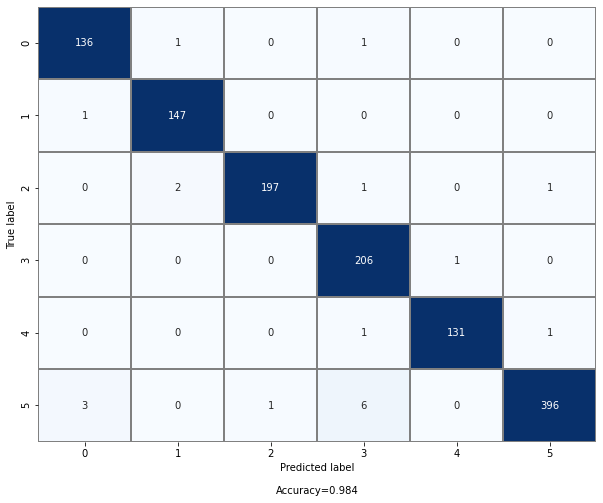

In [50]:
make_confusion_matrix(cf_matrix, figsize=(10,8), cbar=False)